<a href="https://colab.research.google.com/github/SafakKutlu1977/github-pages/blob/main/Final_%C3%96devleri_1_Makine_%C3%96%C4%9Frenmesi_2_Yapay_zeka_uygulamalar%C4%B1_3_Do%C4%9Fal_Dil_i%C5%9Fleme.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

FİNAL PROJELERİ AŞAĞIDADIR. lütfen ekranı Aşağıya doğru kaydırın.

1- Makine Öğrenmesi Final

Mounted at /content/drive
Rastgele seçilen veri boyutu: (10000, 29)
   label  feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0    1.0   0.869293  -0.635082   0.225690   0.327470  -0.689993   0.754202   
1    1.0   0.341495  -1.223359  -1.372971   0.993666   0.691938   1.086187   
2    0.0   0.398960   1.075207  -1.644298   0.638879   0.130816   0.616608   
3    1.0   1.016067   0.560952   1.312664   0.516256  -1.148711   0.536269   
4    1.0   1.702534  -0.370162  -1.019524   0.818844  -1.060859   0.637037   

   feature_7  feature_8  feature_9  ...  feature_19  feature_20  feature_21  \
0  -0.248573  -1.092064   0.000000  ...   -0.010455   -0.045767    3.101961   
1   0.318829  -1.185753   0.000000  ...    1.305406    0.426011    0.000000   
2   0.670360  -1.336543   1.086538  ...   -0.880755   -0.131778    0.000000   
3  -0.610007  -1.516715   0.000000  ...    1.144671   -0.471939    0.000000   
4   0.590152   0.092742   2.173076  ...    0.162773   -1.733257    0

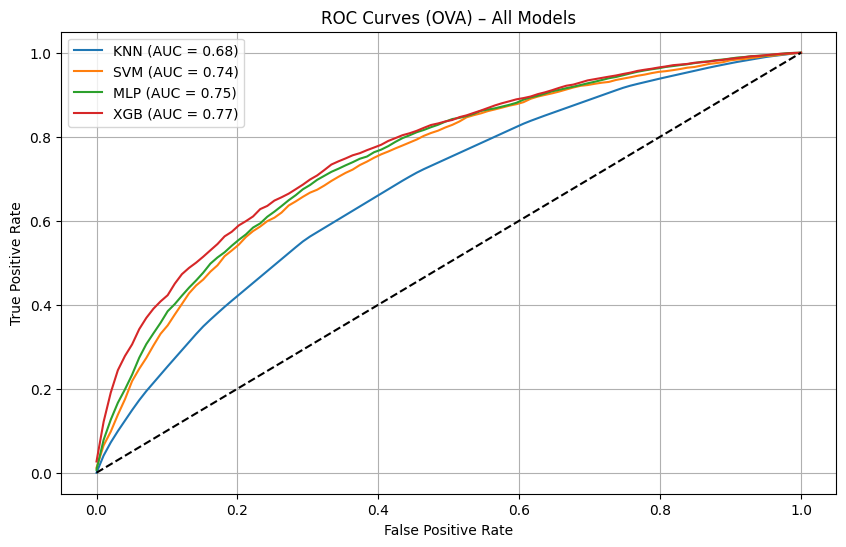

In [1]:
# Gerekli kütüphaneler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore")

# Google Drive'ı bağlanma
from google.colab import drive
drive.mount('/content/drive')

# ---------------------------------------------------------------
# 1. VERİ SETİNDEN BELLEĞE YÜKLEMEDEN RASTGELE 100000 SATIR OKUMA
# ---------------------------------------------------------------
csv_path   = '/content/drive/MyDrive/makineogrenmesifinal/HIGGS.csv'
sample_size = 10000
total_rows  = 11000000  # Dosyadaki toplam satır sayısı

rows_to_skip = sorted(random.sample(range(1, total_rows), total_rows - sample_size))

df = pd.read_csv(csv_path, skiprows=rows_to_skip, header=None)
df.columns = ['label'] + [f'feature_{i}' for i in range(1, 29)]  # Toplam 29 sütun

print(f"Rastgele seçilen veri boyutu: {df.shape}")
print(df.head())

# ----------------------------------------
# 2. ÖN İŞLEME: Aykırı Değer & Ölçekleme
# ----------------------------------------
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

def remove_outliers_iqr(df_, columns):
    for col in columns:
        Q1, Q3 = df_[col].quantile(0.25), df_[col].quantile(0.75)
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
        df_[col] = np.where(df_[col] < lower, lower,
                            np.where(df_[col] > upper, upper, df_[col]))
    return df_

X = remove_outliers_iqr(X.copy(), X.columns)

scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# ----------------------------------------
# 3. ÖZELLİK SEÇİMİ (ANOVA F-TEST)
# ----------------------------------------
selector = SelectKBest(score_func=f_classif, k=15)
X_selected = selector.fit_transform(X_scaled, y)
selected_features = selector.get_support(indices=True)
X_selected = X_scaled.iloc[:, selected_features]

# ----------------------------------------
# 4. MODELLER & NESTED CV (GridSearchCV)
# ----------------------------------------
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

models = {
    'knn': KNeighborsClassifier(),
    'svm': SVC(probability=True),
    'mlp': MLPClassifier(max_iter=300),
    'xgb': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

param_grids = {
    'knn': {'n_neighbors': list(range(3, 12))},
    'svm': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    'mlp': {'hidden_layer_sizes': [(50,), (100,)], 'activation': ['relu', 'tanh']},
    'xgb': {'n_estimators': [100], 'max_depth': [3, 5], 'learning_rate': [0.1]}
}

results = defaultdict(list)

for name, model in models.items():
    print(f"\nModel: {name.upper()}")
    for train_idx, test_idx in outer_cv.split(X_selected, y):
        X_train, X_test = X_selected.iloc[train_idx], X_selected.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        grid = GridSearchCV(model, param_grids[name],
                            cv=inner_cv, scoring='accuracy')
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_

        y_pred = best_model.predict(X_test)
        y_prob = best_model.predict_proba(X_test)[:, 1]

        fpr, tpr, _ = roc_curve(y_test, y_prob)
        results[name].append({
            'accuracy':  accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall':    recall_score(y_test, y_pred),
            'f1':        f1_score(y_test, y_pred),
            'roc_auc':   roc_auc_score(y_test, y_prob),
            'roc_curve': (fpr, tpr)
        })

# ----------------------------------------
# 5. PERFORMANS ÖZETİ
# ----------------------------------------
for name in results:
    print(f"\n{name.upper()} – Ortalama Sonuçlar:")
    for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']:
        metric_scores = [r[metric] for r in results[name]]
        print(f"{metric:9}: {np.mean(metric_scores):.4f}")

# ----------------------------------------
# 6. ROC EĞRİLERİ
# ----------------------------------------
plt.figure(figsize=(10, 6))
for name in results:
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    for r in results[name]:
        fpr, tpr = r['roc_curve']
        tprs.append(np.interp(mean_fpr, fpr, tpr))
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = np.mean([r['roc_auc'] for r in results[name]])
    plt.plot(mean_fpr, mean_tpr, label=f"{name.upper()} (AUC = {mean_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (OVA) – All Models")
plt.legend()
plt.grid(True)
plt.show()


2- Yapay Zeka uygulamaları 90 Şubelik bir restoran zincirinin 15 günlük satış tahmini

In [ ]:
	!pip install optuna
	import pandas as pd
	import numpy as np
	import torch
	import torch.nn as nn
	from torch.utils.data import DataLoader, TensorDataset
	from sklearn.preprocessing import MinMaxScaler
	from sklearn.model_selection import TimeSeriesSplit
	from datetime import datetime
	import optuna

	# ------------------ 1. VERİYİ YÜKLE & TEMİZLE ------------------
	df = pd.read_excel("Satis.xlsx") # Excel dosyasını okumak için read_excel

	# Bozuk tarihleri filtrele
	def is_valid_date(s):
    try:
	        datetime.strptime(s, "%d.%m.%Y")
	        return True
	    except:
	        return False

	df = df[df["Tarih"].apply(is_valid_date)]
	df["Tarih"] = pd.to_datetime(df["Tarih"], format="%d.%m.%Y")

	# Zaman bilgilerini çıkar
	df["Yil"] = df["Tarih"].dt.year
	df["Ay"] = df["Tarih"].dt.month
	df["Gun"] = df["Tarih"].dt.day

	# ------------------ 2. VERİYİ HAZIRLA ------------------
	X = df[["SiparisTuru", "SubeId", "Yil", "Ay", "Gun"]]
	y = df["Satis"]
	# Ölçekleme
	x_scaler = MinMaxScaler()
	X_scaled = x_scaler.fit_transform(X)

	y = y.values.reshape(-1, 1)
	y_scaler = MinMaxScaler()
	y_scaled = y_scaler.fit_transform(y)

	X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
	y_tensor = torch.tensor(y_scaled, dtype=torch.float32)

	# ------------------ 3. LSTM MODELİ ------------------
	class LSTMModel(nn.Module):
	    def __init__(self, input_size, hidden_size, num_layers):
        super().__init__()
	        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
	        self.fc = nn.Linear(hidden_size, 1)

	    def forward(self, x):
	        x = x.unsqueeze(1)  # (batch, seq_len=1, features)
	        lstm_out, _ = self.lstm(x)
	        return self.fc(lstm_out[:, -1, :])

	# ------------------ 4. OPTUNA OPTİMİZASYONU ------------------
	def objective(trial):
	    hidden_size = trial.suggest_int("hidden_size", 16, 128)
	    num_layers = trial.suggest_int("num_layers", 1, 3)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
	    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])

	    model = LSTMModel(input_size=X_tensor.shape[1], hidden_size=hidden_size, num_layers=num_layers)
	    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

	    tscv = TimeSeriesSplit(n_splits=3)
	    losses = []

	    for train_idx, val_idx in tscv.split(X_tensor):
	        train_ds = TensorDataset(X_tensor[train_idx], y_tensor[train_idx])
	        val_ds = TensorDataset(X_tensor[val_idx], y_tensor[val_idx])
	        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False)

	        # Eğitim
	        for epoch in range(10):  # Daha fazla doğruluk istenirse arttırılabilir
	            model.train()
	            for xb, yb in train_loader:
	                optimizer.zero_grad()
	                pred = model(xb)
	                loss = criterion(pred, yb)
	                loss.backward()
                optimizer.step()
		        # Doğrulama
	        model.eval()
	        with torch.no_grad():
            val_pred = model(X_tensor[val_idx])
            val_loss = criterion(val_pred, y_tensor[val_idx])
	            losses.append(val_loss.item())

	    return np.mean(losses)

	# ------------------ 5. OPTUNA ÇALIŞTIR ------------------
	study = optuna.create_study(direction="minimize")
	study.optimize(objective, n_trials=25)  # n_trials arttıkça daha iyi sonuç verir

	print("✅ En iyi parametreler:", study.best_params)


Requirement already satisfied: sqlalchemy>=1.4.2 in /usr/local/lib/python3.11/dist-packages (from optuna) (2.0.41)
Requirement already satisfied: tqdm in /usr/local/lib/python3.11/dist-packages (from optuna) (4.67.1)
Requirement already satisfied: PyYAML in /usr/local/lib/python3.11/dist-packages (from optuna) (6.0.2)
Requirement already satisfied: Mako in /usr/lib/python3/dist-packages (from alembic>=1.5.0->optuna) (1.1.3)
Requirement already satisfied: typing-extensions>=4.12 in /usr/local/lib/python3.11/dist-packages (from alembic>=1.5.0->optuna) (4.14.0)
Requirement already satisfied: greenlet>=1 in /usr/local/lib/python3.11/dist-packages (from sqlalchemy>=1.4.2->optuna) (3.2.2)
<ipython-input-3-bbcebc1b17fd>:24: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Tarih"] = pd.to_datetime(df["Tarih"], format="%d.%m.%Y")
<ipython-input-3-bbcebc1b17fd>:27: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Yil"] = df["Tarih"].dt.year
<ipython-input-3-bbcebc1b17fd>:28: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Ay"] = df["Tarih"].dt.month
<ipython-input-3-bbcebc1b17fd>:29: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Gun"] = df["Tarih"].dt.day
[I 2025-06-09 07:32:55,581] A new study created in memory with name: no-name-c3bf33bc-81ea-4c4e-b06e-0d3288125bda
[I 2025-06-09 07:40:26,638] Trial 0 finished with value: 0.00022881184607588997 and parameters: {'hidden_size': 117, 'num_layers': 2, 'lr': 0.006072053572696841, 'batch_size': 32}. Best is trial 0 with value: 0.00022881184607588997.
[I 2025-06-09 07:43:32,031] Trial 1 finished with value: 0.00022531356565499058 and parameters: {'hidden_size': 67, 'num_layers': 1, 'lr': 0.004955025421269918, 'batch_size': 32}. Best is trial 1 with value: 0.00022531356565499058.
[I 2025-06-09 08:04:18,558] Trial 2 finished with value: 0.00022300375470270714 and parameters: {'hidden_size': 100, 'num_layers': 2, 'lr': 0.0008658422093258643, 'batch_size': 8}. Best is trial 2 with value: 0.00022300375470270714.
[I 2025-06-09 08:10:11,726] Trial 3 finished with value: 0.0002235289430245757 and parameters: {'hidden_size': 79, 'num_layers': 1, 'lr': 0.005575549594249519, 'batch_size': 16}. Best is trial 2 with value: 0.00022300375470270714.
[I 2025-06-09 08:14:12,531] Trial 4 finished with value: 0.00022529299409749606 and parameters: {'hidden_size': 118, 'num_layers': 1, 'lr': 0.004968768569672343, 'batch_size': 32}. Best is trial 2 with value: 0.00022300375470270714.
[I 2025-06-09 08:20:45,324] Trial 5 finished with value: 0.00022468000922041634 and parameters: {'hidden_size': 21, 'num_layers': 2, 'lr': 0.0005913544047955387, 'batch_size': 16}. Best is trial 2 with value: 0.00022300375470270714.
[I 2025-06-09 08:31:02,196] Trial 6 finished with value: 0.00022216358047444373 and parameters: {'hidden_size': 69, 'num_layers': 1, 'lr': 0.0013957552568730966, 'batch_size': 8}. Best is trial 6 with value: 0.00022216358047444373.
[I 2025-06-09 08:34:41,017] Trial 7 finished with value: 0.00023005716987730315 and parameters: {'hidden_size': 104, 'num_layers': 1, 'lr': 0.0002530742831096317, 'batch_size': 32}. Best is trial 6 with value: 0.00022216358047444373.
[I 2025-06-09 08:43:43,543] Trial 8 finished with value: 0.00022440498772387704 and parameters: {'hidden_size': 36, 'num_layers': 3, 'lr': 0.00033341989854686213, 'batch_size': 16}. Best is trial 6 with value: 0.00022216358047444373.
[I 2025-06-09 08:46:33,794] Trial 9 finished with value: 0.0002237646015904223 and parameters: {'hidden_size': 57, 'num_layers': 1, 'lr': 0.0004532488307743516, 'batch_size': 32}. Best is trial 6 with value: 0.00022216358047444373.
[I 2025-06-09 09:05:41,869] Trial 10 finished with value: 0.00022544683209465197 and parameters: {'hidden_size': 47, 'num_layers': 3, 'lr': 0.00010134802626091302, 'batch_size': 8}. Best is trial 6 with value: 0.00022216358047444373.
[I 2025-06-09 09:24:44,674] Trial 11 finished with value: 0.00022240257142887762 and parameters: {'hidden_size': 86, 'num_layers': 2, 'lr': 0.0017057839093699153, 'batch_size': 8}. Best is trial 6 with value: 0.00022216358047444373.
[I 2025-06-09 09:43:11,053] Trial 12 finished with value: 0.00022232194896787405 and parameters: {'hidden_size': 83, 'num_layers': 2, 'lr': 0.0019902582173357787, 'batch_size': 8}. Best is trial 6 with value: 0.00022216358047444373.
[I 2025-06-09 10:02:23,984] Trial 13 finished with value: 0.00022254421977171054 and parameters: {'hidden_size': 85, 'num_layers': 2, 'lr': 0.0018705235797942725, 'batch_size': 8}. Best is trial 6 with value: 0.00022216358047444373.
[I 2025-06-09 10:23:10,415] Trial 14 finished with value: 0.00022309024158554772 and parameters: {'hidden_size': 64, 'num_layers': 3, 'lr': 0.00215243685892612, 'batch_size': 8}. Best is trial 6 with value: 0.00022216358047444373.
[I 2025-06-09 10:35:27,094] Trial 15 finished with value: 0.00022552232743085673 and parameters: {'hidden_size': 98, 'num_layers': 1, 'lr': 0.0026817551848905205, 'batch_size': 8}. Best is trial 6 with value: 0.00022216358047444373.
[I 2025-06-09 10:50:19,737] Trial 16 finished with value: 0.00022228087861246118 and parameters: {'hidden_size': 51, 'num_layers': 2, 'lr': 0.001292354647396314, 'batch_size': 8}. Best is trial 6 with value: 0.00022216358047444373.
[I 2025-06-09 11:08:44,734] Trial 17 finished with value: 0.0002223054034402594 and parameters: {'hidden_size': 43, 'num_layers': 3, 'lr': 0.001036717122074962, 'batch_size': 8}. Best is trial 6 with value: 0.00022216358047444373.
[I 2025-06-09 11:17:38,183] Trial 18 finished with value: 0.0002225003408966586 and parameters: {'hidden_size': 21, 'num_layers': 1, 'lr': 0.0010547817828133832, 'batch_size': 8}. Best is trial 6 with value: 0.00022216358047444373.
[I 2025-06-09 11:32:45,373] Trial 19 finished with value: 0.00022837408081007501 and parameters: {'hidden_size': 54, 'num_layers': 2, 'lr': 0.0034105490198746108, 'batch_size': 8}. Best is trial 6 with value: 0.00022216358047444373.
[I 2025-06-09 11:46:23,596] Trial 20 finished with value: 0.00022914629274358353 and parameters: {'hidden_size': 30, 'num_layers': 2, 'lr': 0.0002145616303471894, 'batch_size': 8}. Best is trial 6 with value: 0.00022216358047444373.
[I 2025-06-09 12:05:03,399] Trial 21 finished with value: 0.00022250199496435621 and parameters: {'hidden_size': 43, 'num_layers': 3, 'lr': 0.0011065722205456966, 'batch_size': 8}. Best is trial 6 with value: 0.00022216358047444373.
[I 2025-06-09 12:26:05,194] Trial 22 finished with value: 0.00022340880726308873 and parameters: {'hidden_size': 59, 'num_layers': 3, 'lr': 0.0006926790995509472, 'batch_size': 8}. Best is trial 6 with value: 0.00022216358047444373.
[I 2025-06-09 12:45:33,324] Trial 23 finished with value: 0.00022271183358194926 and parameters: {'hidden_size': 47, 'num_layers': 3, 'lr': 0.0012738747795153806, 'batch_size': 8}. Best is trial 6 with value: 0.00022216358047444373.
[I 2025-06-09 12:54:17,469] Trial 24 finished with value: 0.0002212882051632429 and parameters: {'hidden_size': 32, 'num_layers': 3, 'lr': 0.003340441269150742, 'batch_size': 16}. Best is trial 24 with value: 0.0002212882051632429.
✅ En iyi parametreler: {'hidden_size': 32, 'num_layers': 3, 'lr': 0.003340441269150742, 'batch_size': 16}


In [ ]:
# ------------------ 6. EN İYİ MODEL İLE EĞİT ------------------
best_params = study.best_params
best_model = LSTMModel(
    input_size=X_tensor.shape[1],
    hidden_size=best_params["hidden_size"],
    num_layers=best_params["num_layers"]
)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(best_model.parameters(), lr=best_params["lr"])
train_loader = DataLoader(TensorDataset(X_tensor, y_tensor), batch_size=best_params["batch_size"], shuffle=False)

for epoch in range(20):  # Gerekirse artır
    best_model.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = best_model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()

# ------------------ 7. TAHMİNLERİ AL & YENİDEN ÖLÇEKLE ------------------
best_model.eval()
with torch.no_grad():
    y_pred_scaled = best_model(X_tensor).numpy()

y_pred = y_scaler.inverse_transform(y_pred_scaled)
df["Tahmin"] = y_pred

# ------------------ 8. GRAFİKLEŞTİR ------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df["Tarih"], df["Satis"], label="Gerçek Satış", marker='o')
plt.plot(df["Tarih"], df["Tahmin"], label="Tahmin Satış", marker='x')
plt.xlabel("Tarih")
plt.ylabel("Satış")
plt.title("Gerçek vs Tahmin Satışlar")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------ 9. EXCEL'E KAYDET ------------------
df.to_excel("Tahmin_Sonuclari.xlsx", index=False)
print("📁 Tahminler 'Tahmin_Sonuclari.xlsx' dosyasına kaydedildi.")


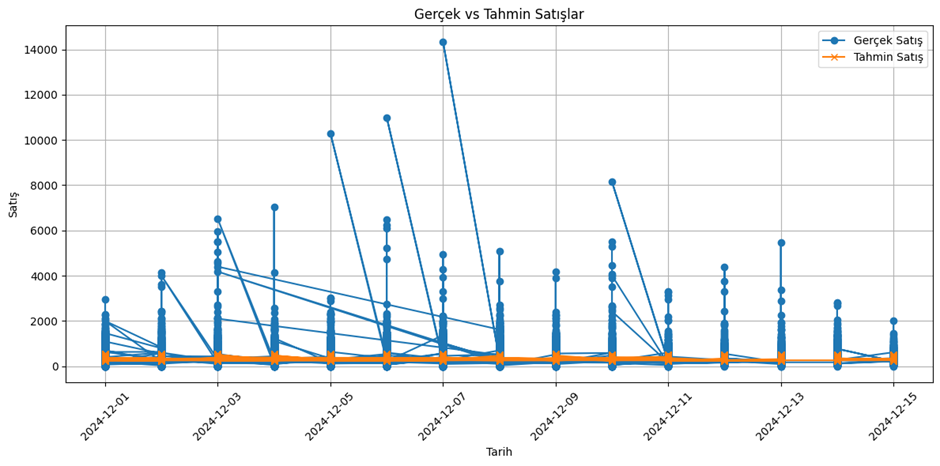

SiparisTuru	Tarih	SubeId	Satis	 	Yil	Ay	Gun	Tahmin
3	2024-12-01 00:00:00	101	270		2024	12	1	350,1481
2	2024-12-01 00:00:00	232	175		2024	12	1	307,1065
1	2024-12-01 00:00:00	232	260		2024	12	1	297,031
7	2024-12-01 00:00:00	232	306		2024	12	1	263,9128
3	2024-12-01 00:00:00	184	136		2024	12	1	336,2778
1	2024-12-01 00:00:00	177	205		2024	12	1	352,7566
1	2024-12-01 00:00:00	177	80		2024	12	1	352,7566
1	2024-12-01 00:00:00	177	395		2024	12	1	352,7566
9	2024-12-01 00:00:00	37	215		2024	12	1	321,5598
1	2024-12-01 00:00:00	234	250		2024	12	1	294,5795
1	2024-12-01 00:00:00	208	80		2024	12	1	324,9905
7	2024-12-01 00:00:00	213	308,75		2024	12	1	264,1989
1	2024-12-01 00:00:00	203	250		2024	12	1	330,2397
7	2024-12-01 00:00:00	166	124,5		2024	12	1	265,9456
7	2024-12-01 00:00:00	166	184,5		2024	12	1	265,9456
3	2024-12-01 00:00:00	128	516		2024	12	1	355,0018
7	2024-12-01 00:00:00	128	120		2024	12	1	260,4242
9	2024-12-01 00:00:00	14	157,5		2024	12	1	320,8249
7	2024-12-01 00:00:00	14	303,76		2024	12	1	259,5325
7	2024-12-01 00:00:00	169	160		2024	12	1	266,0447
3	2024-12-01 00:00:00	148	140,25		2024	12	1	352,4418
9	2024-12-01 00:00:00	148	271,15		2024	12	1	324,503
7	2024-12-01 00:00:00	209	122,26		2024	12	1	264,3437
6	2024-12-01 00:00:00	156	315		2024	12	1	267,6234
3	2024-12-01 00:00:00	91	258,25		2024	12	1	341,7629
7	2024-12-01 00:00:00	91	423		2024	12	1	258,4745
7	2024-12-01 00:00:00	212	190		2024	12	1	264,2322
9	2024-12-01 00:00:00	156	300		2024	12	1	324,835
7	2024-12-01 00:00:00	223	204		2024	12	1	263,9708
1	2024-12-01 00:00:00	226	640		2024	12	1	304,9154


3- Doğal dil işleme: Duygu Analizi

In [ ]:
# Gerekli kütüphaneleri
import numpy as np
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# NLTK verilerini indir
# NLTK verilerini indir
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab') # Download the missing 'punkt_tab' data package

# 1. Veri setini yükle
column_names = ['target', 'ids', 'date', 'flag', 'user', 'text']
data = pd.read_csv('training.csv', encoding='latin-1', names=column_names)

# 2. Temizleme fonksiyonu
def clean_tweet(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'\@\w+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'RT[\s]+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    return text.strip()

# 3. Ön işleme fonksiyonu
def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [token.lower() for token in tokens]
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

# 4. Temizleme ve ön işleme
data['text'] = data['text'].fillna('')
data['cleaned_text'] = data['text'].apply(clean_tweet)
data['preprocessed_text'] = data['cleaned_text'].apply(preprocess_text)

# 5. Tokenizer ve padding
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(data['preprocessed_text'])
sequences = tokenizer.texts_to_sequences(data['preprocessed_text'])
X = pad_sequences(sequences, maxlen=100)

# 6. Etiketleri hazırla (0 = Negative, 4 = Positive)
# Original: y = data['target'].values
y = data['target'].values
y[y == 4] = 2  # Replace 4 with 2 for positive sentiment

# y = data['target'].apply(lambda x: 0 if x == 0 else (1 if x == 2 else 2)).values  # Convert to 0, 1, and 2
# 7. Kelime sayısını al
vocab_size = min(len(tokenizer.word_index) + 1, 10000)

# 8. Eğitim/test bölme
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 9. Model tanımı
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=100))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))  # 3 sınıf: 0, 2, belki 4

# 10. Model derleme
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 11. Model eğitimi
model.fit(X_train, y_train, epochs=2, batch_size=128, validation_split=0.1)

# 12. Test değerlendirme
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Accuracy: {accuracy:.4f}")

# 13. Yeni metinler için tahmin
new_texts = ["This product is great!", "I hated this movie.", "It's okay, not the best."]

# Yeni metinleri ön işleyelim
new_texts_cleaned = [clean_tweet(t) for t in new_texts]
new_texts_preprocessed = [preprocess_text(t) for t in new_texts_cleaned]
new_sequences = tokenizer.texts_to_sequences(new_texts_preprocessed)
new_input = pad_sequences(new_sequences, maxlen=100)

# Tahmin yap
predictions = model.predict(new_input)

# Sınıf isimleri
labels = ['Negative', 'Neutral', 'Positive']

# Tahminleri yazdır
for text, pred in zip(new_texts, predictions):
    sentiment = labels[np.argmax(pred)]
    print(f"Text: {text} - Sentiment: {sentiment}")


nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
Epoch 1/2
9000/9000 ━━━━━━━━━━━━━━━━━━━━ 5707s 634ms/step - accuracy: 0.7567 - loss: 0.4928 - val_accuracy: 0.7886 - val_loss: 0.4465
Epoch 2/2
9000/9000 ━━━━━━━━━━━━━━━━━━━━ 5759s 640ms/step - accuracy: 0.7939 - loss: 0.4375 - val_accuracy: 0.7935 - val_loss: 0.4387
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 416s 42ms/step - accuracy: 0.7935 - loss: 0.4407

Test Accuracy: 0.7936
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
Text: This product is great! - Sentiment: Positive
Text: I hated this movie. - Sentiment: Negative
Text: It's okay, not the best. - Sentiment: Positive
